In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.utils import torch_mod_to_fcn

from sparse_networks import CenteredBumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import plot_2d_f
from sparse_networks import SumOfBumpFcns


## Define objects

In [3]:
class PWL_NNNetwork_MD(torch.nn.Module):
    """ Piecewise linear nearest neighbor network"""
    
    def __init__(self, init_centers: torch.Tensor, init_weights: torch.Tensor, 
                 init_offsets: torch.Tensor, k: int = 1):
        """ Creates a new PWL_NNNetwork. 
        
        Args:
                
            init_centers: Initial centeres for each function. Of shape n_ctrs*input_dim
            
            init_weights: Initial weights for each function. Of shape n_ctrs*input_dim*output_dim
            
            init_offsets: Initial offsets for each function. Of shape n_ctrs*output_dim
                      
            k: Number of nearest neighbors to use. 
        """
        
        super().__init__()
        
        self.k = k
        self.n_fcns = init_centers.shape[0]
        self.d_in = init_centers.shape[1]
             
        self.ctrs = torch.nn.Parameter(init_centers)
        self.wts = torch.nn.Parameter(init_weights)
        self.offsets = torch.nn.Parameter(init_offsets)
    
    def forward(self, x: torch.Tensor):
        """ Computes output from input. 
        
        Args:
        
            x: Input of shape n_smps*input_dim
            
        Returns: 
            y: Output of shape n_smps*output_dim
        """

        # Find the k closest centers to each data point
        with torch.no_grad():
            ctrs_expanded = torch.reshape(self.ctrs, [self.n_fcns, 1, self.d_in])
            diffs = x - ctrs_expanded
            sq_distances = torch.sum(diffs**2, dim=2)
            top_k_indices = torch.topk(-sq_distances, k=self.k, dim=0).indices
            
        # Compute linear functions applied to each input data point
        selected_wts = self.wts[top_k_indices]
        selected_ctrs = self.ctrs[top_k_indices]
        
        applied_wts = torch.sum(selected_wts, dim=0)
        applied_offsets = (torch.sum(self.offsets[top_k_indices], dim=0) - 
                                torch.sum(torch.sum(selected_wts*selected_ctrs.unsqueeze(3), dim=0),dim=1))
        
        return torch.sum(applied_wts*x.unsqueeze(2),1) + applied_offsets

    def bound(self, ctr_bounds: Sequence = [0, 1], bound_fcns: bool =  True):
        """  Applies bounds to the centers.

        Bounds are applied element-wise.

        Args:

            ctr_bounds: The bounds to force centers to be between. If None, no bounds are enforced.
            
            bound_fcns: True if bound should be called on functiions. 

        """

        if ctr_bounds is not None:
            small_inds = self.ctrs < ctr_bounds[0]
            big_inds = self.ctrs > ctr_bounds[1]
            self.ctrs.data[small_inds] = ctr_bounds[0]
            self.ctrs.data[big_inds] = ctr_bounds[1]
        

In [4]:
class PWL_NNNetwork(torch.nn.Module):
    """ Piecewise linear nearest neighbor network"""
    
    def __init__(self, init_centers: torch.Tensor, init_weights: torch.Tensor, 
                 init_offsets: torch.Tensor, k: int = 1):
        """ Creates a new PWL_NNNetwork. 
        
        Args:
                
            init_centers: Initial centeres for each function. Of shape n_ctrs*input_dim
            
            init_weights: Initial weights for each function. Of shape n_ctrs*input_dim
            
            init_offsets: Initial offsets for each function. Of length n_ctrs
                      
            k: Number of nearest neighbors to use. 
        """
        
        super().__init__()
        
        self.k = k
        self.n_fcns = init_centers.shape[0]
        self.d_in = init_centers.shape[1]
             
        self.ctrs = torch.nn.Parameter(init_centers)
        self.wts = torch.nn.Parameter(init_weights)
        self.offsets = torch.nn.Parameter(init_offsets)
    
    def forward(self, x: torch.Tensor):
        """ Computes output from input. 
        
        Args:
        
            x: Input of shape n_smps*input_dim
            
        Returns: 
            y: Output of shape n_smps*output_dim
        """

        # Find the k closest centers to each data point
        with torch.no_grad():
            ctrs_expanded = torch.reshape(self.ctrs, [self.n_fcns, 1, self.d_in])
            diffs = x - ctrs_expanded
            sq_distances = torch.sum(diffs**2, dim=2)
            top_k_indices = torch.topk(-sq_distances, k=self.k, dim=0).indices
            
        # Compute linear functions applied to each input data point
        selected_wts = self.wts[top_k_indices]
        selected_ctrs = self.ctrs[top_k_indices]
        
        applied_wts = torch.sum(selected_wts, dim=0)
        applied_offsets = (torch.sum(self.offsets[top_k_indices], dim=0) - 
                           torch.sum(torch.sum(selected_wts*selected_ctrs, dim=0), dim=1))
        
        return torch.sum(applied_wts*x, dim=1) + applied_offsets
    
    def bound(self, ctr_bounds: Sequence = [0, 1], bound_fcns: bool =  True):
        """  Applies bounds to the centers.

        Bounds are applied element-wise.

        Args:

            ctr_bounds: The bounds to force centers to be between. If None, no bounds are enforced.
            
            bound_fcns: True if bound should be called on functiions. 

        """

        if ctr_bounds is not None:
            small_inds = self.ctrs < ctr_bounds[0]
            big_inds = self.ctrs > ctr_bounds[1]
            self.ctrs.data[small_inds] = ctr_bounds[0]
            self.ctrs.data[big_inds] = ctr_bounds[1]
        

In [5]:
class MultiLayerNetwork(torch.nn.Module):
    
    def __init__(self, d_in: int, layer_1_d_out = 4, n_layer_1_modules: int = 2, n_layer_1_fcns: int = 10, 
                 layer_1_k: int = 4, n_layer_2_fcns: int = 10, layer_2_k=1):
        
        super().__init__()
        
        layer_1_modules = list()
        batch_norm_modules = list()
        for m_i in range(n_layer_1_modules):
            ctrs = torch.rand([n_layer_1_fcns, d_in])
            weights = torch.randn([n_layer_1_fcns, d_in, layer_1_d_out])
            offsets = torch.zeros(n_layer_1_fcns, layer_1_d_out)
            pwl_nn = PWL_NNNetwork_MD(init_centers=ctrs, init_weights=weights, init_offsets=offsets, k=layer_1_k)
            layer_1_modules.append(pwl_nn)
            batch_norm_modules.append(torch.nn.BatchNorm1d(layer_1_d_out, affine=False))
                    
        self.layer_1_modules = torch.nn.ModuleList(layer_1_modules)
        self.batch_norm_modules = torch.nn.ModuleList(batch_norm_modules)
        
        layer_2_d_in = layer_1_d_out*n_layer_1_modules
        layer_2_init_ctrs = torch.rand(n_layer_2_fcns, layer_2_d_in)
        layer_2_init_weights = torch.rand(n_layer_2_fcns, layer_2_d_in)
        layer_2_init_offsets = torch.zeros(n_layer_2_fcns)
        self.layer_2_network = PWL_NNNetwork(init_centers=layer_2_init_ctrs, init_weights=layer_2_init_weights,
                                             init_offsets=layer_2_init_offsets, k=layer_2_k)
                
    def forward(self, x: torch.Tensor):
    
        layer_1_out = [b_n(m(x)) for b_n, m in zip(self.batch_norm_modules, self.layer_1_modules)]
        #layer_1_out = [m(x) for  m in self.layer_1_modules]
        layer_1_out = torch.cat(layer_1_out, dim=1)
        return self.layer_2_network(layer_1_out)
    
    def bound(self): 
        pass
        

In [204]:
class DeepPWLNetwork(torch.nn.Module):
    
    def __init__(self, d_in: int, n_composite_layers: int = 2, 
                 n_pre_fcns: int = 10, pre_d_out: int = 10, pre_k=1, 
                 n_post_fcns: int = 10, post_d_out = 3, post_k=1, 
                 n_final_fcns: int = 10, final_k=1):
    
        super().__init__()
    
        if n_composite_layers < 2:
            raise(ValueError('n_layers must be greater than 1'))
    
    
        layers = list()
        for m_in in range(n_composite_layers - 1):
        
            if m_in == 0:
                cur_d_in = d_in
            else:
                cur_d_in = post_d_out
        
  
            # Setup networks for each composite layer 
            pre_ctrs = torch.rand([n_pre_fcns, cur_d_in])
            pre_weights = .001*torch.randn([n_pre_fcns, cur_d_in, pre_d_out])
            pre_offsets = torch.zeros(n_pre_fcns, pre_d_out)
            pre_net = PWL_NNNetwork_MD(init_centers=pre_ctrs, 
                                       init_weights=pre_weights, 
                                       init_offsets=pre_offsets, 
                                       k=pre_k)
        
            pre_batch_norm = torch.nn.BatchNorm1d(pre_d_out, affine=False)
        
            post_ctrs = torch.rand([n_post_fcns, pre_d_out])
            post_weights = .001*torch.randn([n_post_fcns, pre_d_out, post_d_out])
            post_offsets = torch.zeros(n_post_fcns, post_d_out)
            post_net = PWL_NNNetwork_MD(init_centers=post_ctrs, 
                                        init_weights=post_weights, 
                                        init_offsets=post_offsets, 
                                        k=post_k)
        
            post_batch_norm = torch.nn.BatchNorm1d(post_d_out, affine=False)
        
            comp_layer_1 = torch.nn.Sequential(pre_net, pre_batch_norm, post_net, post_batch_norm)
        
            layers.append(comp_layer_1)
        
        # Setup final layer
        final_ctrs = torch.rand([n_final_fcns, post_d_out])
        final_weights = .001*torch.randn([n_final_fcns, post_d_out])
        final_offsets = torch.zeros(n_final_fcns)
        
        final_layer = PWL_NNNetwork(init_centers=final_ctrs, init_weights=final_weights, 
                                    init_offsets=final_offsets, k=final_k)
    
        layers.append(final_layer)
    
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor): 
        return self.layers(x)
    
    def bound(self):
        pass
        
        
        
        
    

## Fitting function

In [205]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
        
        update_int: Interval updates are printed
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Generate a ground-truth function we want to fit and visualize it

In [307]:
fcn_generator = FunctionSequenceGenerator(n_bumps = 5000, bump_peak_vl_range = [-1, 1], cov_ev_range = [.002, .002])
f_true = fcn_generator.generate(1)

x = np.random.rand(10000,2)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

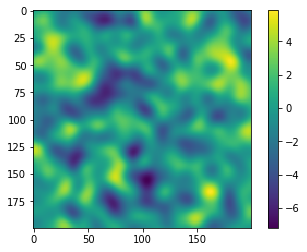

In [308]:
plot_2d_f(f_true, n_smps_per_dim=200)

## Now fit the function

In [323]:
run_on_gpu = True
n_fcns = 10
k = 5

In [324]:
init_centers = torch.rand(n_fcns, 2)
init_weights = torch.ones(n_fcns, 2)
init_offsts = torch.zeros(n_fcns)

fit_f = MultiLayerNetwork(d_in=2, n_layer_1_fcns=500, n_layer_1_modules=1, layer_1_d_out=1, 
                          n_layer_2_fcns=1)

In [330]:
fit_f = DeepPWLNetwork(d_in=2, n_composite_layers= 2, 
                 n_pre_fcns=250, pre_d_out=2, pre_k=1, 
                 n_post_fcns=250, post_d_out =2, post_k=1, 
                 n_final_fcns=5, final_k=1)

In [331]:
if run_on_gpu:
    fit_f.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_f.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [332]:
lr = .001
enforce_bounds=True
batch_size = 5000

t0 = time.time()

fit(fit_f, x, y, n_its = 3000, lr=lr, batch_size=batch_size, enforce_bounds=enforce_bounds, update_int=100)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 4.755685e+00
It 100: 3.953559e+00
It 200: 2.986196e+00
It 300: 2.500514e+00
It 400: 2.003513e+00
It 500: 1.618550e+00
It 600: 1.272461e+00
It 700: 9.468063e-01
It 800: 6.904152e-01
It 900: 5.242954e-01
It 1000: 3.667156e-01
It 1100: 2.551063e-01
It 1200: 2.587269e-01
It 1300: 2.360184e-01
It 1400: 2.416971e-01
It 1500: 1.652733e-01
It 1600: 1.659617e-01
It 1700: 1.495123e-01
It 1800: 1.540663e-01
It 1900: 1.592217e-01
It 2000: 1.466034e-01
It 2100: 1.585272e-01
It 2200: 1.547887e-01
It 2300: 1.505830e-01
It 2400: 1.781088e-01
It 2500: 1.595296e-01
It 2600: 1.501354e-01
It 2700: 1.478294e-01
It 2800: 1.576191e-01
It 2900: 1.420397e-01
Elapsed time: 22.041399478912354


In [333]:
fit_f.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

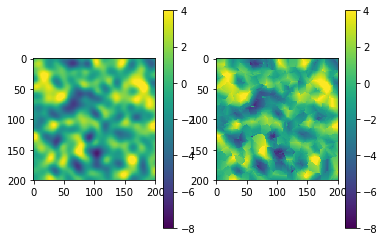

In [334]:
plt.subplot(1,2,1)
plot_2d_f(f_true, n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-8,4)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_f), n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-8,4)